# **ALBUM ART GENERATOR**

In [1]:
import jax
import jax.numpy as jnp

In [2]:
#make sure the gpu is being used
jax.local_device_count()

1

In [3]:
#make directories for the datasets
!mkdir dalle-mini
!mkdir dalle-mini/vqgan

In [4]:
#install the datasets
!pip install -q dalle-mini
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

     |████████████████████████████████| 53 kB 926 kB/s 
     |████████████████████████████████| 1.9 MB 27.7 MB/s 
     |████████████████████████████████| 240 kB 74.0 MB/s 
     |████████████████████████████████| 189 kB 61.4 MB/s 
     |████████████████████████████████| 235 kB 63.3 MB/s 
     |████████████████████████████████| 41 kB 258 kB/s 
     |████████████████████████████████| 5.8 MB 46.2 MB/s 
     |████████████████████████████████| 237 kB 58.9 MB/s 
     |████████████████████████████████| 8.3 MB 30.4 MB/s 
     |████████████████████████████████| 154 kB 65.3 MB/s 
     |████████████████████████████████| 51 kB 3.3 MB/s 
     |████████████████████████████████| 85 kB 2.4 MB/s 
     |████████████████████████████████| 7.6 MB 53.8 MB/s 
     |████████████████████████████████| 182 kB 81.2 MB/s 
     |████████████████████████████████| 168 kB 74.3 MB/s 
     |████████████████████████████████| 182 kB 70.3 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |██████████████████

In [7]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from dalle_mini import DalleBart, DalleBartProcessor #change "from transformers.generation_flax_utils import FlaxSampleOutput" to "from transformers.generation.flax_utils import FlaxSampleOutput" in dalle_mini
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel
from huggingface_hub import hf_hub_url, cached_download, hf_hub_download
import shutil

dalle_mini_files_list = ['config.json', 'tokenizer.json', 
             'tokenizer_config.json', 'merges.txt', 'vocab.json', 
             'special_tokens_map.json', 'enwiki-words-frequency.txt', 
             'flax_model.msgpack']

#download dalle dataset
for each_file in dalle_mini_files_list:
  downloaded_file = hf_hub_download("dalle-mini/dalle-mini", filename=each_file)
  target_path = '/content/dalle-mini/' + each_file
  shutil.copy(downloaded_file, target_path)

#set dalle dataset model location
DALLE_MODEL_LOCATION = '/content/dalle-mini'
DALLE_COMMIT_ID = None
model, params = DalleBart.from_pretrained(    
    DALLE_MODEL_LOCATION, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False,
)

Downloading:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/497 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

In [12]:
vqgan_files_list = ['config.json',  'flax_model.msgpack']

for each_file in vqgan_files_list:
  downloaded_file = hf_hub_download("dalle-mini/vqgan_imagenet_f16_16384", filename=each_file)
  target_path = '/content/dalle-mini/vqgan/' + each_file
  shutil.copy(downloaded_file, target_path)

#set decoder dataset location
VQGAN_LOCAL_REPO = '/content/dalle-mini/vqgan'
VQGAN_LCOAL_COMMIT_ID = None
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_LOCAL_REPO, revision=VQGAN_LCOAL_COMMIT_ID, _do_init=False
)

#set train location
DALLE_MODEL_LOCATION = '/content/dalle-mini'
DALLE_COMMIT_ID = None
processor = DalleBartProcessor.from_pretrained(
    DALLE_MODEL_LOCATION, 
    revision=DALLE_COMMIT_ID)

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/304M [00:00<?, ?B/s]

In [13]:
#parameters
from flax.jax_utils import replicate
from functools import partial

params = replicate(params)
vqgan_params = replicate(vqgan_params)

@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
  return model.generate(
      **tokenized_prompt,
      prng_key=key,
      params=params,
      top_k=top_k,
      top_p=top_p,
      temperature=temperature,
      condition_scale=condition_scale,
  )

@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

In [14]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

# number of predictions per prompt
#this is for testing, the user now inputs their choice of predictions
#n_predictions = 4

#for customizating generation parameters (https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

In [15]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image, ImageOps, ImageDraw, ImageFont, ImageFilter
from tqdm.notebook import trange

Enter your prompt: Yosemite
How many images do you want? (max 5): 5
Do you want a black and white version? (y for yes): y
Do you want the image to have a border? (y for yes): y
Enter the border color (ex. white, blue, etc.): lightgoldenrodyellow
Do you want text on the cover? (y for yes): y
Enter the text: Yosemite
Enter the text color (ex. white, blue, etc.): white

1. Top Left
2. Bottom Left
3. Top Right
4. Bottom Right
5. Middle
6. Top Middle
7. Bottom Middle
Where do you want the text? (enter the number): 4

1. Small
2. Medium
3. Large
What do you want the size of the text to be? (enter the number): 1
Do you want to add blur to the image (text will not be blurred)? (y for yes): n
Prompt:  Yosemite


  0%|          | 0/5 [00:00<?, ?it/s]

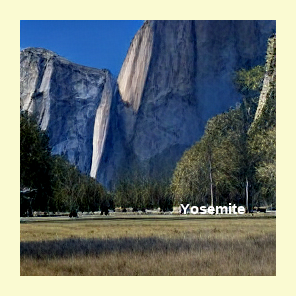

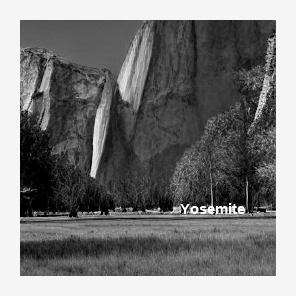

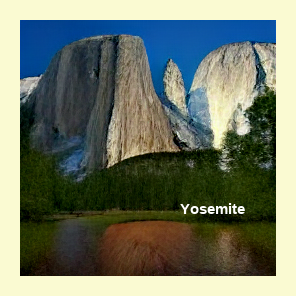

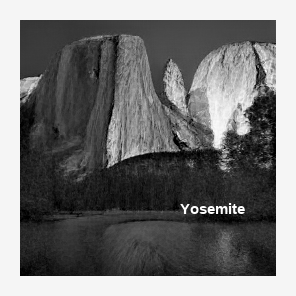

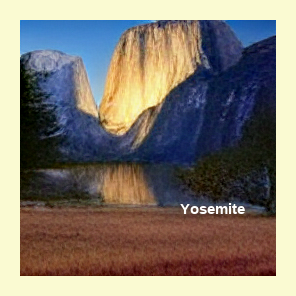

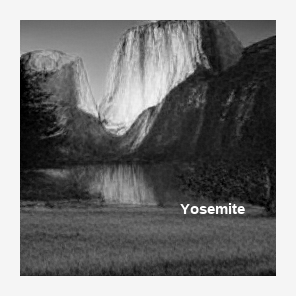

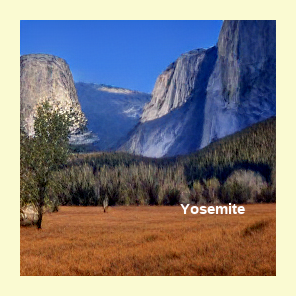

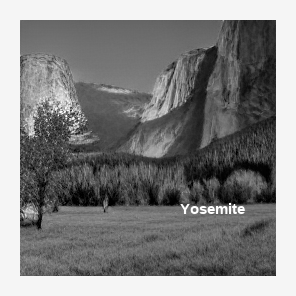

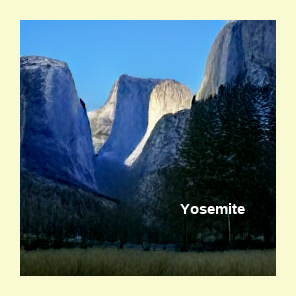

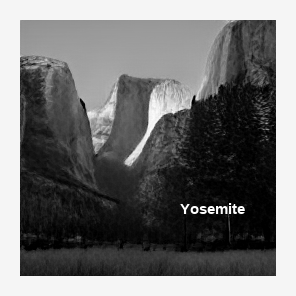

In [54]:
#define default flags for customization
BW = 0
border = 0
textOn = 0
blur = 0

userInput = input("Enter your prompt: ")

prompts = [userInput]
tokenized_prompts = processor(prompts)
tokenized_prompt = replicate(tokenized_prompts)


n_predictions = input("How many images do you want? (max 5): ")
n_predictions = int(n_predictions)

if n_predictions > 5:
  n_predictions = 5 #limit to 5 predictions

userInput2 = input("Do you want a black and white version? (y for yes): ")
if userInput2 == 'y':
  BW = 1

userInput2 = input("Do you want the image to have a border? (y for yes): ")
if userInput2 == 'y':
  border = 1
  color = input("Enter the border color (ex. white, blue, etc.): ") #acceptable colors: (https://www.computerhope.com/jargon/w/w3c-color-names.htm)

userInput2 = input("Do you want text on the cover? (y for yes): ")
if userInput2 == 'y':
  textOn = 1
  text = input("Enter the text: ")
  textColor = input("Enter the text color (ex. white, blue, etc.): ") #acceptable colors: (https://www.computerhope.com/jargon/w/w3c-color-names.htm)
  textLoc = input("\n1. Top Left\n2. Bottom Left\n3. Top Right\n4. Bottom Right\n5. Middle\n6. Top Middle\n7. Bottom Middle\nWhere do you want the text? (enter the number): ")
  textLoc = int(textLoc)
  textSizeInput = input("\n1. Small\n2. Medium\n3. Large\nWhat do you want the size of the text to be? (enter the number): ")
  textSizeInput = int(textSizeInput)

  if textSizeInput == 1:
    textSize = 15
  elif textSizeInput == 2:
    textSize = 30
  elif textSizeInput == 3:
    textSize = 45
  else:
    textSize = 15 #default is small

userInput2 = input("Do you want to add blur to the image (text will not be blurred)? (y for yes): ")
if userInput2 == 'y':
  blur = 1


print("Prompt: ", *prompts)

images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for decoded_img in decoded_images:
        img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
        images.append(img)
        
        if(blur == 1):
          img = img.filter(ImageFilter.BLUR)
          #display(img)
        
        if(textOn == 1):
          I1 = ImageDraw.Draw(img)
          #I1.text((28, 36), text, fill=(textColor))
          #myFont = ImageFont.truetype(size = 10)
          myFont = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', textSize)
          if textLoc == 1:
            I1.text((32, 32), text, font=myFont, fill =(textColor))
          elif textLoc == 2:
            I1.text((32, 190), text, font=myFont, fill =(textColor))
          elif textLoc == 3:
            I1.text((180, 32), text, font=myFont, fill =(textColor))
          elif textLoc == 4:
            I1.text((160, 180), text, font=myFont, fill =(textColor))
          elif textLoc == 5:
            I1.text((87, 100), text, font=myFont, fill =(textColor), align ='center')
          elif textLoc == 6:
            I1.text((87, 32), text, font=myFont, fill =(textColor), align ='center')
          elif textLoc == 7:
            I1.text((87, 180), text, font=myFont, fill =(textColor), align ='center')
          else:
            I1.text((32, 32), text, font=myFont, fill =(textColor)) #top left by default
        
        if(border == 1):
          img = ImageOps.expand(img,border=20,fill=color)
        
        display(img)

        #black and white version
        if BW == 1:
          grayscale = img.convert('L')
          display(grayscale)
        print()